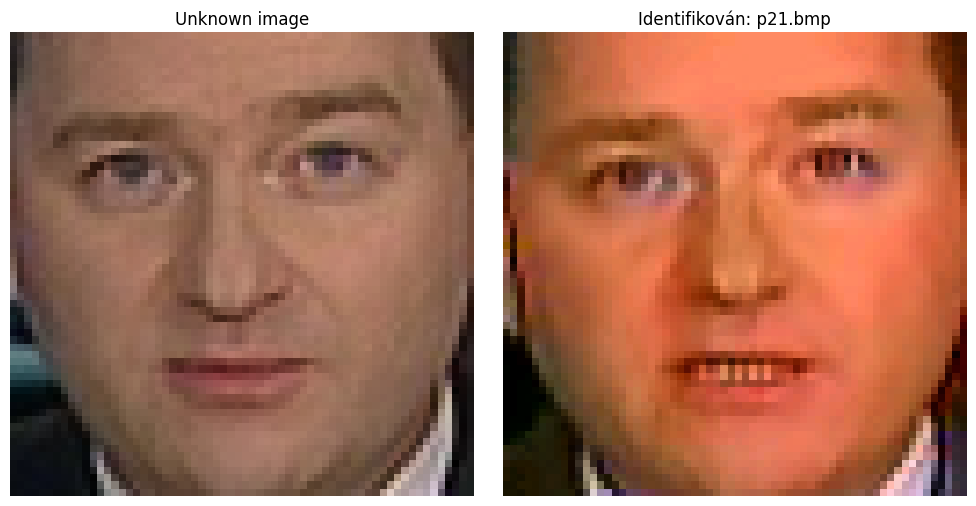

In [ ]:
# made by Martin "Granc3k" Šimon

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# PATHs
unknown_path = "./data/unknown.bmp"  # unknown obrázek
known_dir = "./data/test"  # folder se vzory

# Load unknown obrázku a get rozměrů
sample_img = cv2.imread(os.path.join(known_dir, os.listdir(known_dir)[0]))
img_shape = sample_img.shape[:2]  # (výška, šířka) - ignor kanálů (barevné)

# Load ostatních dat
known_images = []
image_names = []

for fname in sorted(os.listdir(known_dir)):
    if fname.endswith(".bmp"):
        img = cv2.imread(os.path.join(known_dir, fname))
        img = cv2.resize(img, (img_shape[1], img_shape[0]))  # union velikosti
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # transfer na gray pro PCA
        known_images.append(img_gray.flatten())  # save jako 1D vektor
        image_names.append(fname)  # name obrázku pro pozdější výpis

# Prep dat pro PCAčko
X = np.array(known_images, dtype=np.float32)  # matice, kde každý řádek je 1 obrázek
mean_face = np.mean(X, axis=0)  # průměr všech obrazů
X_centered = X - mean_face  # odcentrování

# PCA calc pomocí eigenvectorů
C = np.cov(X_centered, rowvar=False)  # kovarianční matice
eig_vals, eig_vecs = np.linalg.eig(C)  # calc vlastních čísel a vektorů
idx = np.argsort(-eig_vals)  # sort sestupně podle velikosti
eig_vecs = eig_vecs[:, idx]  # přeuspořádáme vektory

# Project do podprostoru
k = 10  # kolik hlavních komponent použít
E = eig_vecs[:, :k]  # první k komponenta
projected_known = np.dot(X_centered, E)  # projekce známých vzorů

# Prep unknown obrázku
unknown_img = cv2.imread(unknown_path)  # load unknown obrázku pro plot
unknown_img = cv2.resize(unknown_img, (img_shape[1], img_shape[0]))
unknown_gray = cv2.cvtColor(unknown_img, cv2.COLOR_BGR2GRAY)
unknown_flat = unknown_gray.flatten().astype(np.float32)
unknown_centered = unknown_flat - mean_face
projected_unknown = np.dot(unknown_centered, E)  # projekce do PCA prostoru

# Calc euklidovské vzdálenosti
distances = np.linalg.norm(projected_known - projected_unknown, axis=1)
best_match_index = np.argmin(distances)
best_match_name = image_names[best_match_index]

# Load obrázku nejlepší schody
best_match_img = cv2.imread(os.path.join(known_dir, best_match_name))
best_match_img = cv2.resize(best_match_img, (img_shape[1], img_shape[0]))

# Plot výsledků
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(cv2.cvtColor(unknown_img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Unknown image")
axs[0].axis("off")

axs[1].imshow(cv2.cvtColor(best_match_img, cv2.COLOR_BGR2RGB))
axs[1].set_title(f"Identifikován: {best_match_name}")
axs[1].axis("off")

plt.tight_layout()
plt.show()